In [5]:
from tqdm import tqdm
import time

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, KeyedVectors
import gensim

import tensorflow as tf
import keras

from tensorflow.keras.layers import Embedding, Dense, GRU, Flatten, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant

from tensorflow.python.client import device_lib

tf.test.is_built_with_cuda()

True

In [9]:
total_data = pd.read_csv('./save_data/naver_review.csv')
total_data['label'] = np.select([total_data.score>3],[1],default=0)

In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

In [40]:
train_data.drop_duplicates(subset=['review'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 149626


In [11]:
mecab = Mecab('C:/mecab/mecab-ko-dic')
stopwords = pd.read_csv('./save_data/stop_word.csv')
tmp = stopwords.values.tolist()
stopwords = []
for s in tmp:
    stopwords.append(*s)

train_data['tokenized'] = train_data['review'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['review'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [15]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\max82\AppData\Local\Temp\ipykernel_15628\2845544308.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [19]:
train_data['review'] = train_data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

Unnamed: 0    0
score         0
review        0
label         0
tokenized     0
dtype: int64


C:\Users\max82\AppData\Local\Temp\ipykernel_15628\3946236247.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [21]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49995


C:\Users\max82\AppData\Local\Temp\ipykernel_15628\1082388108.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\max82\AppData\Local\Temp\ipykernel_15628\1082388108.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [22]:
X_train = train_data['tokenized'].values
Y_train = train_data['label'].values
X_test= test_data['tokenized'].values
Y_test = test_data['label'].values

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42132
등장 빈도가 2번 이하인 희귀 단어의 수: 24765
단어 집합에서 희귀 단어의 비율: 58.77954998575904
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1626681353164774


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17368


In [27]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
Y_train = np.array(train_data['label'])
Y_test = np.array(test_data['label'])

In [30]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [32]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
Y_train = np.delete(Y_train, drop_train, axis=0)
print(len(X_train))
print(len(Y_train))

149622
149622


리뷰의 최대 길이 : 87
리뷰의 평균 길이 : 16.961750277365628


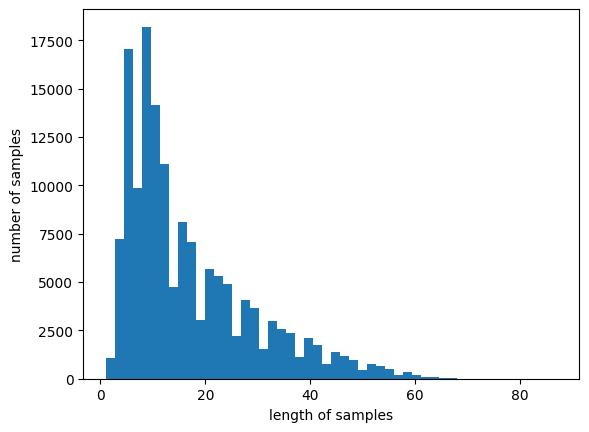

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [46]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 93.6954458568927


In [47]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [69]:
model_only_reviewdata = gensim.models.Word2Vec.load('./model/only_review.model')
print('리뷰만 읽은 데이터')
print(model_only_reviewdata.wv.vectors.shape)
#모델별 단어 수, 벡터의 차원수들
#OR = only review data
OR_vocab_size = len(X_train)
OR_vector_dim = 200
OR_embedding_matrix = np.zeros((OR_vocab_size,200))
print(np.shape(OR_embedding_matrix))

def get_vector(word, word2vec_model):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None
    
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word, model_only_reviewdata.wv)
    if vector_value is not None :
        OR_embedding_matrix[index] = vector_value

리뷰만 읽은 데이터
(23916, 200)
(149622, 200)


In [78]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec, KeyedVectors
import gensim
from tensorflow.keras.initializers import Constant
hidden_units = 128
model = Sequential()
model.add(Embedding(OR_vocab_size,OR_vector_dim, embeddings_initializer=Constant(OR_embedding_matrix)))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='relu'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1870/1871 [============================>.] - ETA: 0s - loss: 0.4711 - acc: 0.8344
Epoch 1: val_acc improved from -inf to 0.89397, saving model to ./model\LSTM.h5
1871/1871 [==============================] - 87s 46ms/step - loss: 0.4711 - acc: 0.8344 - val_loss: 0.3677 - val_acc: 0.8940
Epoch 2/15
1871/1871 [==============================] - ETA: 0s - loss: 0.3437 - acc: 0.8980
Epoch 2: val_acc improved from 0.89397 to 0.89784, saving model to ./model\LSTM.h5
1871/1871 [==============================] - 85s 45ms/step - loss: 0.3437 - acc: 0.8980 - val_loss: 0.4081 - val_acc: 0.8978
Epoch 3/15
1871/1871 [==============================] - ETA: 0s - loss: 0.3511 - acc: 0.8888
Epoch 3: val_acc improved from 0.89784 to 0.90035, saving model to ./model\LSTM.h5
1871/1871 [==============================] - 83s 44ms/step - loss: 0.3511 - acc: 0.8888 - val_loss: 0.2922 - val_acc: 0.9004
Epoch 4/15
1870/1871 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9214
Epoch 4

In [ ]:
#모델 로드
loaded_model = load_model('./model/LSTM.h5')

In [79]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

1563/1563 [==============================] - 8s 5ms/step - loss: 0.3962 - acc: 0.8928

 테스트 정확도: 0.8928


In [80]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [81]:
time_sum = 0
t1 = time.time()
print(sentiment_predict('이거 진짜 좋아요 ㅠㅠ'))
t2 = time.time()

time_sum += (t2 - t1)
print(time_sum)

1/1 [==============================] - 0s 337ms/step
92.75% 확률로 긍정 리뷰입니다.

None
0.37000489234924316
